1. Dimensionality reduction and data visualization

Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Function to detect target column

In [2]:
def detect_target_column(data):
    for col in data.columns:
        if len(data[col].unique()) <= 10:  # Assuming target column has few unique values
            return col
    raise ValueError("No suitable target column detected.")

Function to preprocess data

In [3]:
def preprocess_data(csv_path):
    data = pd.read_csv(csv_path)
    print("Initial data shape:", data.shape)
    
    # Automatically detect target column
    target_column = detect_target_column(data)
    print(f"Detected target column: {target_column}")
    
    # Separate features and target
    features = data.drop(target_column, axis=1)
    
    # Convert all non-numeric columns to numeric if possible
    for col in features.columns:
        if features[col].dtype == 'object':
            try:
                features[col] = pd.to_numeric(features[col], errors='coerce')
            except ValueError:
                pass
    
    # Fill missing values after conversion
    features = features.fillna(0)
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    return pd.DataFrame(scaled_features, columns=features.columns), data[target_column]

Function to visualize dimensionality reduction

In [4]:
def visualize_dimensionality_reduction(X, y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(X)
    
    plt.figure(figsize=(16, 7))
    
    # PCA plot
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_encoded, cmap='viridis', s=10, alpha=0.7)
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class')
    
    # t-SNE plot
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_encoded, cmap='viridis', s=10, alpha=0.7)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Class')
    
    plt.show()

Main function

Initial data shape: (100, 12)
Detected target column: Gender


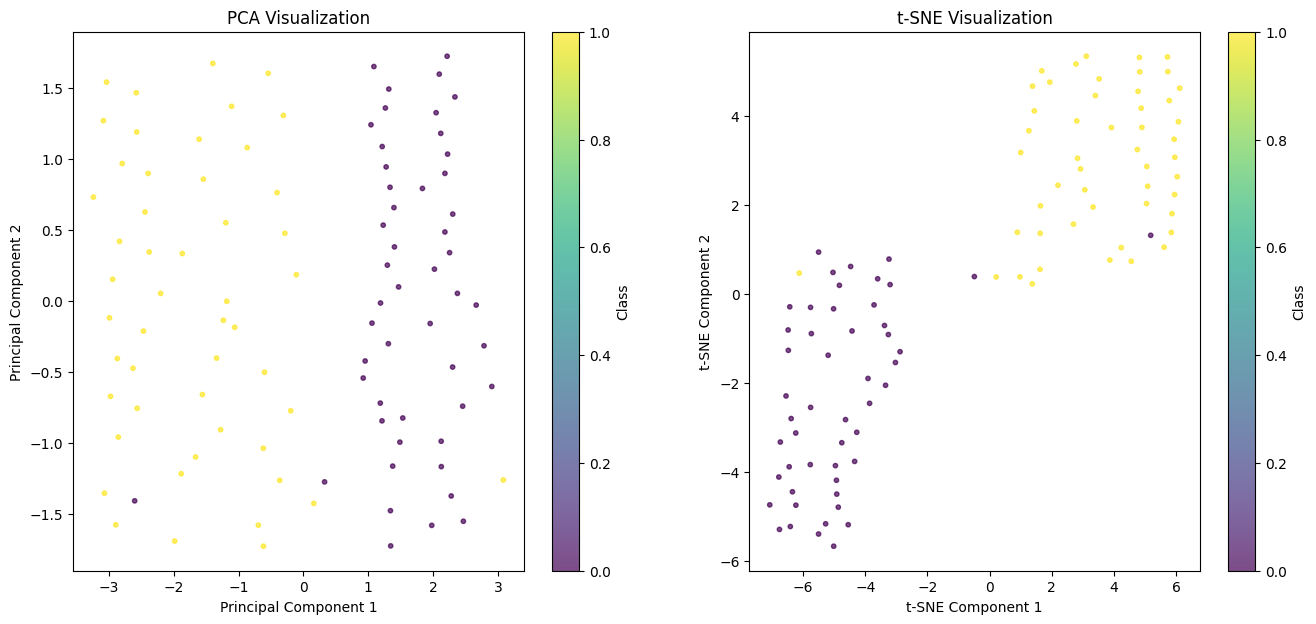

In [5]:
if __name__ == "__main__":
    # Request user input for CSV file path
    csv_path = input("Enter the path to the CSV file: ")
    try:
        X, y = preprocess_data(csv_path)
        visualize_dimensionality_reduction(X, y)
    except ValueError as e:
        print(f"Error during processing: {e}")

2. Cluster analysis

Import libraries

In [6]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image

Function to apply k-means quantization to an image

In [7]:
def kmeans_quantize_image(image_path, n_colors):
    image = Image.open(image_path)
    image = image.convert('RGB')
    
    # Convert image to numpy array
    image_data = np.array(image)
    
    # Reshape image to 2D array of pixels
    pixels = image_data.reshape((-1, 3))
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    
    # Replace each pixel value with its corresponding cluster center
    quantized_pixels = kmeans.cluster_centers_[kmeans.labels_].astype(int)
    
    # Reshape back to original image dimensions
    quantized_image = quantized_pixels.reshape(image_data.shape)
    
    # Convert the result back to an image
    quantized_image = Image.fromarray(quantized_image.astype('uint8'))
    
    return quantized_image

Function to display quantized images

In [8]:
def display_quantized_images(image_path):
    depths = [64, 32, 16, 8]
    plt.figure(figsize=(12, 8))
    
    for i, depth in enumerate(depths):
        quantized_image = kmeans_quantize_image(image_path, depth)
        plt.subplot(2, 2, i + 1)
        plt.imshow(quantized_image)
        plt.title(f'{depth}-level Quantization')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Main function

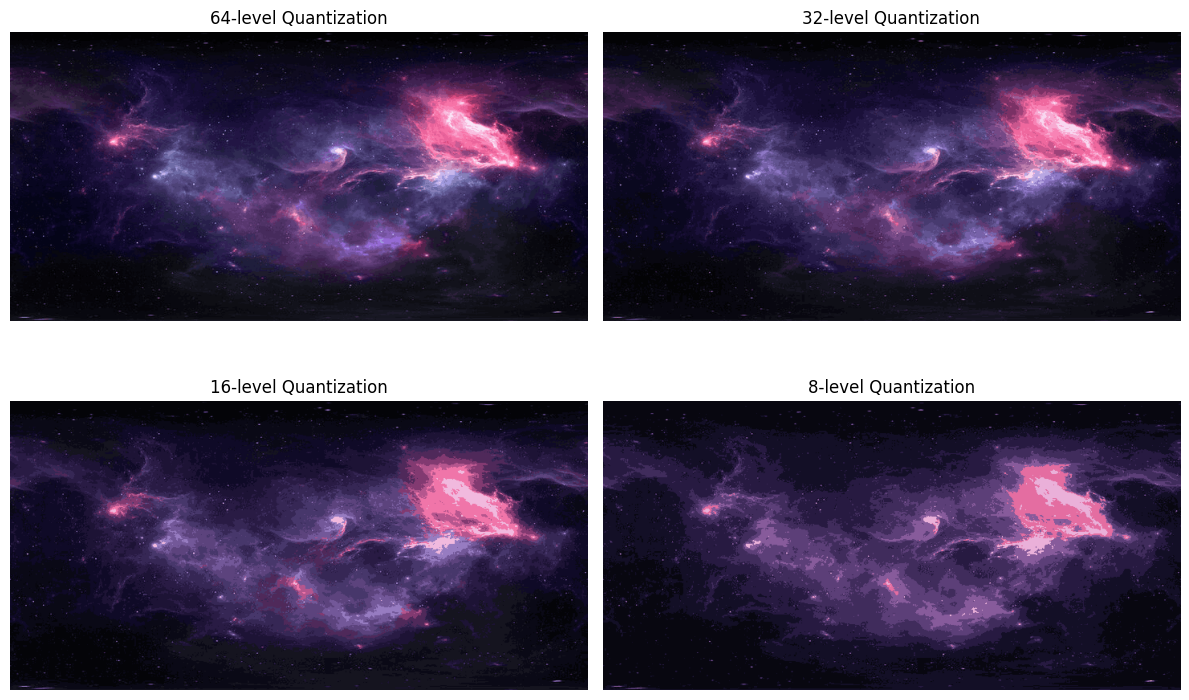

In [9]:
if __name__ == "__main__":
    # Request user input for image file path
    image_path = input("Enter the path to the image file: ")
    display_quantized_images(image_path)

3. Processing and classification of text data

Import libraries

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

Function to detect text and label columns

In [11]:
def detect_columns(data):
    text_column = None
    label_column = None
    
    for col in data.columns:
        unique_values = len(data[col].unique())
        
        if data[col].dtype == 'object' and unique_values > 10:
            text_column = col
        elif unique_values <= 10 and col != 'id':  # Assuming 'id' column is not a label column
            label_column = col
            
    if text_column is None or label_column is None:
        raise ValueError("Could not automatically detect text or label column.")
    
    return text_column, label_column

Load and preprocess data

In [12]:
def load_data(csv_path):
    data = pd.read_csv(csv_path, index_col=0)  # Load data using the first column as an index
    print("Columns in the dataset:", data.columns)
    
    text_column, label_column = detect_columns(data)
    print(f"Detected text column: {text_column}")
    print(f"Detected label column: {label_column}")
    
    # Remove text columns, leaving only numerical data for features
    features = data.select_dtypes(include=[np.number])
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(data[label_column])
    
    return pd.DataFrame(scaled_features, columns=features.columns), encoded_labels, data[text_column]

Train and evaluate classifier

In [13]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=1))  # Add zero_division parameter

Visualize word cloud for each class

In [14]:
def visualize_wordclouds_for_classes(texts, labels):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    # Preprocess texts
    processed_texts = [" ".join([word for word in text.split() if word.lower() not in stop_words and word.isalnum()]) for text in texts]
    df = pd.DataFrame({'text': processed_texts, 'label': labels})

    unique_labels = df['label'].unique()

    for label in unique_labels:
        text = " ".join(df[df['label'] == label]['text'])
        wordcloud = WordCloud(width=800, height=400, max_words=100).generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

Main function

Columns in the dataset: Index(['User Rating', 'Age Group Targeted', 'Price', 'Platform',
       'Requires Special Device', 'Developer', 'Publisher', 'Release Year',
       'Genre', 'Multiplayer', 'Game Length (Hours)', 'Graphics Quality',
       'Soundtrack Quality', 'Story Quality', 'User Review Text', 'Game Mode',
       'Min Number of Players'],
      dtype='object')
Detected text column: User Review Text
Detected label column: Min Number of Players
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1558
           1       1.00      1.00      1.00      1574
           2       1.00      1.00      1.00      1590
           3       1.00      1.00      1.00      1569
           4       1.00      1.00      1.00      1575
           5       1.00      1.00      1.00      1660
           6       1.00      1.00      1.00      1557
           7       1.00      1.00      1.00      1622
           8       1.00      1.00      1.00      1628

 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


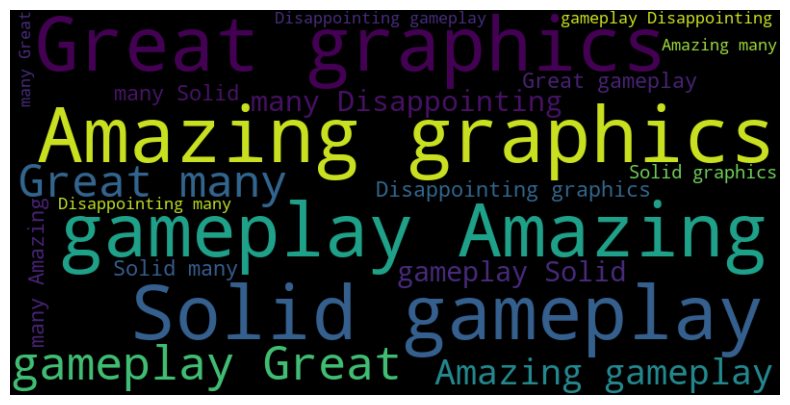

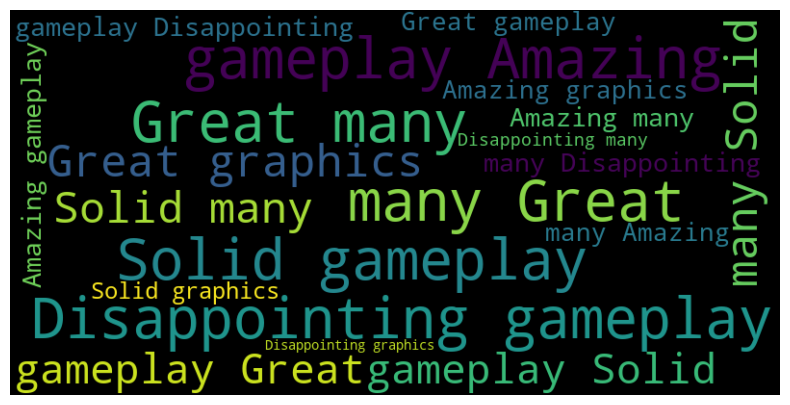

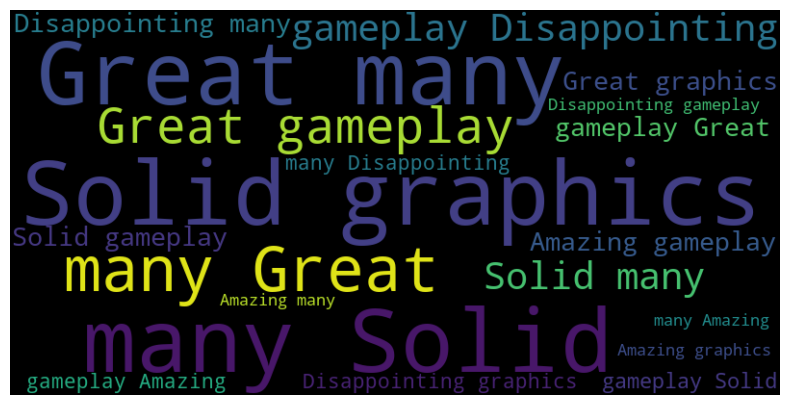

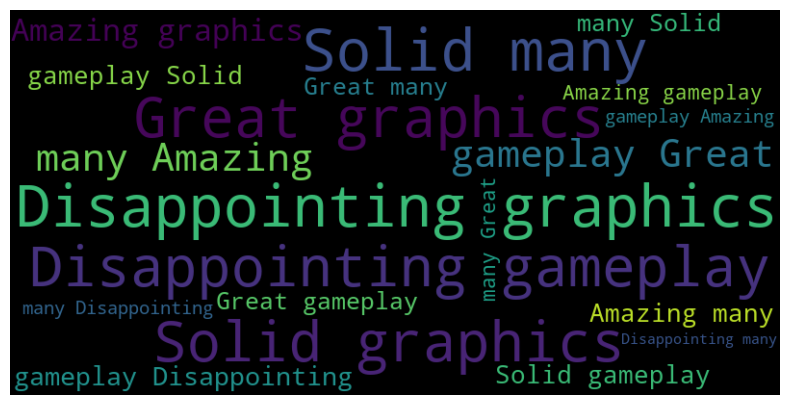

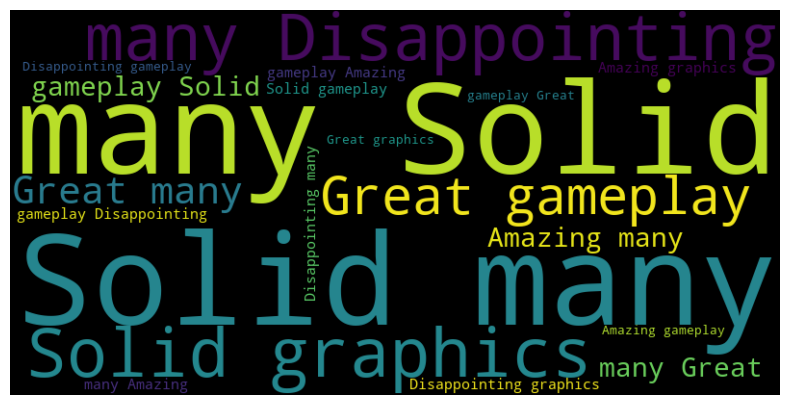

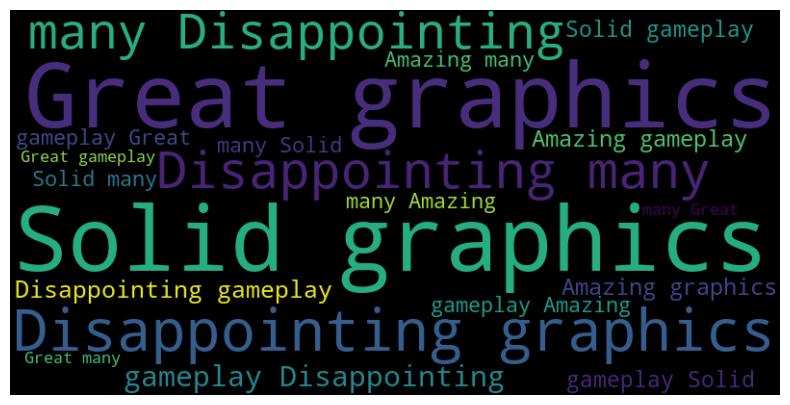

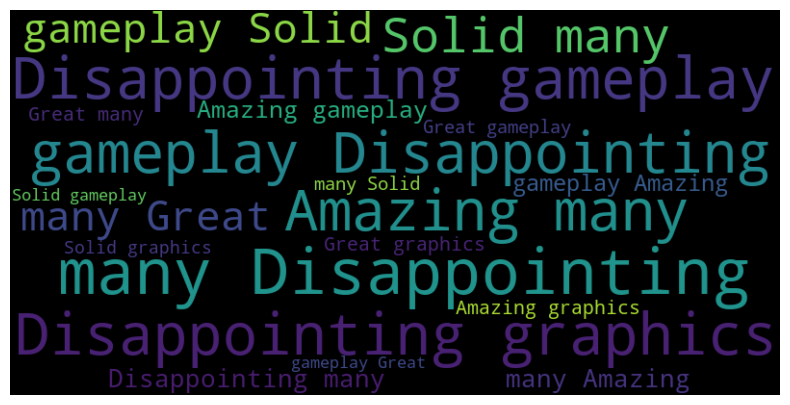

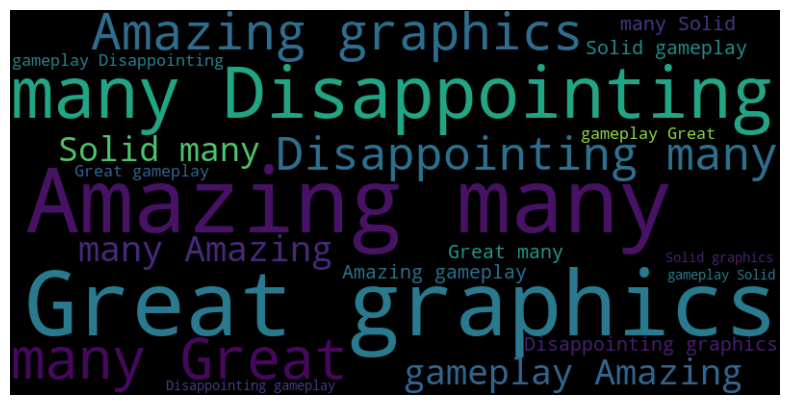

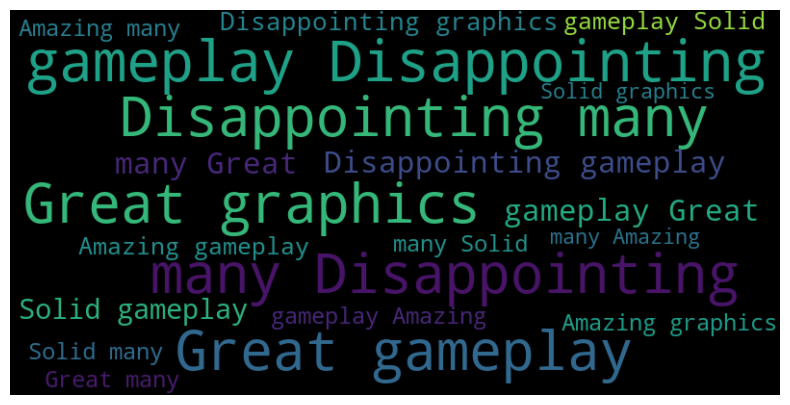

In [15]:
if __name__ == "__main__":
    # Request user input for CSV file path
    csv_path = input("Enter the path to the CSV file: ")
    X, y, texts = load_data(csv_path)
    
    # Train and evaluate classifier
    train_and_evaluate(X, y)
    
    # Visualize word clouds for classes
    visualize_wordclouds_for_classes(texts, y)